[View in Colaboratory](https://colab.research.google.com/github/irhallac/deep_learning_examples/blob/master/CIFAR_TENSORBOARD_COLAB.ipynb)

In [1]:
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop

import matplotlib.pyplot as plt

from keras.callbacks import TensorBoard
from google.colab import files

Using TensorFlow backend.


In [0]:
import os
import requests
import shutil
import subprocess
import tensorflow as tf

__all__ = [
  'install_ngrok', 
  'launch_tensorboard',
]

def __shell__(cmd, split=True):
  # get_ipython().system_raw(cmd)
  result = get_ipython().getoutput(cmd, split=split)
  if result and not split:
    result = result.strip('\n')
  return result  


# tested OK
def install_ngrok(bin_dir="/tmp"):
  """ download and install ngrok on local vm instance
  Args:
    bin_dir: full path for the target directory for the `ngrok` binary
  """
  TARGET_DIR = bin_dir
  CWD = os.getcwd()
  is_grok_avail = os.path.isfile(os.path.join(TARGET_DIR,'ngrok'))
  if is_grok_avail:
    print("ngrok installed")
  else:
    import platform
    plat = platform.platform() # 'Linux-4.4.64+-x86_64-with-Ubuntu-17.10-artful'
    if 'x86_64' in plat:
      
      os.chdir('/tmp')
      print("calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ..." )
      get_ipython().system_raw( "wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip" )
      print("calling unzip ngrok-stable-linux-amd64.zip ...")
      get_ipython().system_raw( "unzip ngrok-stable-linux-amd64.zip" )
      os.rename("ngrok", "{}/ngrok".format(TARGET_DIR))
      os.remove("ngrok-stable-linux-amd64.zip")
      is_grok_avail = os.path.isfile(os.path.join(TARGET_DIR,'ngrok'))
      os.chdir(TARGET_DIR)
      if is_grok_avail:
        print("ngrok installed. path={}".format(os.path.join(TARGET_DIR,'ngrok')))
      else:
        # ValueError: ERROR: ngrok not found, path=
        raise ValueError( "ERROR: ngrok not found, path=".format(TARGET_DIR) )
    else:
      raise NotImplementedError( "ERROR, ngrok install not configured for this platform, platform={}".format(plat))
    os.chdir(CWD)
    return
    
# tested OK
def launch_tensorboard(bin_dir="/tmp", log_dir="/tmp", retval=False):
  """returns a public tensorboard url based on the ngrok package
  checks if `ngrok` is available, and installs, if necessary, to `bin_dir`
  launches tensorboard, if necessary
  see: https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab
  Args:
    bin_dir: full path for the target directory for the `ngrok` binary
    log_dir: full path for the tensorflow `log_dir`
  Return:
    public url for tensorboard if retval==True
      NOTE: the method will print a link to stdout (cell output) for the tensorflow URL. 
      But the link printed from the return value has an extra "%27" in the URL which causes an error
  """
  install_ngrok(bin_dir)
    
  if not tf.gfile.Exists(log_dir):  tf.gfile.MakeDirs(log_dir)
  
  # check status of tensorboard and ngrok
  ps = __shell__("ps -ax")
  is_tensorboard_running = len([f for f in ps if "tensorboard" in f ]) > 0
  is_ngrok_running = len([f for f in ps if "ngrok" in f ]) > 0
  print("status: tensorboard={}, ngrok={}".format(is_tensorboard_running, is_ngrok_running))

  if not is_tensorboard_running:
    get_ipython().system_raw(
        'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
        .format(log_dir)
    )
    is_tensorboard_running = True
    
  if not is_ngrok_running:  
    #    grok should be installed in /tmp/ngrok
    get_ipython().system_raw('{}/ngrok http 6006 &'.format(bin_dir))
    is_ngrok_running = True

  # get tensorboard url
  # BUG: getting connection refused for HTTPConnectionPool(host='localhost', port=4040)
  #     on first run, retry works
  import time
  time.sleep(3)
  retval = requests.get('http://localhost:4040/api/tunnels')
  tensorboard_url = retval.json()['tunnels'][0]['public_url'].strip()
  print("tensorboard url=", tensorboard_url)
  if retval:
    return tensorboard_url


In [3]:
# set paths
ROOT = %pwd
LOG_DIR = os.path.join(ROOT, 'log1')

# will install `ngrok`, if necessary
# will create `log_dir` if path does not exist
launch_tensorboard( bin_dir=ROOT, log_dir=LOG_DIR )

calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ...
calling unzip ngrok-stable-linux-amd64.zip ...
ngrok installed. path=/content/ngrok
status: tensorboard=False, ngrok=False
('tensorboard url=', u'http://13add4aa.ngrok.io')


u'http://13add4aa.ngrok.io'

In [0]:
IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

BATCH_SIZE = 128
NB_EPOCH = 25
NB_CLASSES = 10
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIM = RMSprop()

In [5]:


(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
 

Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES) 


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

129572864/170498071 [=====================>........] - ETA: 12s

170508288/170498071 [==============================] - 47s 0us/step
('X_train shape:', (50000, 32, 32, 3))
(50000, 'train samples')
(10000, 'test samples')


In [0]:
#print(Y_train[0:5])
#print(y_train[0:5])
#print(Y_test[-1])
#print(y_test[-1])

In [0]:
#print(X_train[0])

In [0]:
#TO DO
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [7]:
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16777728  
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
__________

In [0]:

tensorboard = TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=True, write_images=True)


**End of ToDo1**

In [10]:

model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, validation_split=VALIDATION_SPLIT, callbacks=[tensorboard], verbose=VERBOSE)

print('Testing...')
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)

print("Test score:", score[0])
print('Test accuracy:', score[1])

model_json = model.to_json()
open('cifar10_architecture.json', 'w').write(model_json)
model.save_weights('cifar10_weights.h5', overwrite=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 18s 440us/step - loss: 1.7138 - acc: 0.4074 - val_loss: 1.3575 - val_acc: 0.5316
Epoch 2/25
36736/40000 [==========================>...] - ETA: 1s - loss: 1.3175 - acc: 0.5342

40000/40000 [==============================] - 17s 415us/step - loss: 1.3143 - acc: 0.5359 - val_loss: 1.1944 - val_acc: 0.5932
Epoch 3/25
40000/40000 [==============================] - 17s 413us/step - loss: 1.1730 - acc: 0.5870 - val_loss: 1.1422 - val_acc: 0.5984
Epoch 4/25
21120/40000 [==============>...............] - ETA: 7s - loss: 1.0720 - acc: 0.6241

40000/40000 [==============================] - 17s 414us/step - loss: 1.0741 - acc: 0.6244 - val_loss: 1.1052 - val_acc: 0.6206
Epoch 5/25
40000/40000 [==============================] - 16s 412us/step - loss: 0.9953 - acc: 0.6524 - val_loss: 1.0873 - val_acc: 0.6241
Epoch 6/25
19200/40000 [=============>................] - ETA: 8s - loss: 0.9304 - acc: 0.6792

40000/40000 [==============================] - 16s 412us/step - loss: 0.9294 - acc: 0.6790 - val_loss: 1.0404 - val_acc: 0.6481
Epoch 7/25
40000/40000 [==============================] - 16s 412us/step - loss: 0.8701 - acc: 0.6947 - val_loss: 1.1082 - val_acc: 0.6221
Epoch 8/25
19200/40000 [=============>................] - ETA: 8s - loss: 0.8051 - acc: 0.7215

40000/40000 [==============================] - 17s 414us/step - loss: 0.8214 - acc: 0.7169 - val_loss: 1.0201 - val_acc: 0.6573
Epoch 9/25
40000/40000 [==============================] - 17s 414us/step - loss: 0.7758 - acc: 0.7313 - val_loss: 1.0598 - val_acc: 0.6685
Epoch 10/25
16768/40000 [===========>..................] - ETA: 8s - loss: 0.7271 - acc: 0.7484

40000/40000 [==============================] - 17s 414us/step - loss: 0.7367 - acc: 0.7467 - val_loss: 1.0518 - val_acc: 0.6676
Epoch 11/25
40000/40000 [==============================] - 17s 414us/step - loss: 0.6970 - acc: 0.7612 - val_loss: 1.0040 - val_acc: 0.6726
Epoch 12/25
14976/40000 [==========>...................] - ETA: 9s - loss: 0.6439 - acc: 0.7772

40000/40000 [==============================] - 17s 416us/step - loss: 0.6691 - acc: 0.7706 - val_loss: 1.0319 - val_acc: 0.6803
Epoch 13/25
40000/40000 [==============================] - 17s 414us/step - loss: 0.6408 - acc: 0.7804 - val_loss: 1.1359 - val_acc: 0.6544
Epoch 14/25
14592/40000 [=========>....................] - ETA: 9s - loss: 0.5911 - acc: 0.7939

40000/40000 [==============================] - 17s 413us/step - loss: 0.6102 - acc: 0.7903 - val_loss: 1.0954 - val_acc: 0.6735
Epoch 15/25
40000/40000 [==============================] - 17s 414us/step - loss: 0.5880 - acc: 0.7990 - val_loss: 1.1120 - val_acc: 0.6722
Epoch 16/25
14208/40000 [=========>....................] - ETA: 10s - loss: 0.5706 - acc: 0.8102

40000/40000 [==============================] - 17s 417us/step - loss: 0.5713 - acc: 0.8074 - val_loss: 1.1955 - val_acc: 0.6690
Epoch 17/25
40000/40000 [==============================] - 17s 416us/step - loss: 0.5518 - acc: 0.8135 - val_loss: 1.1530 - val_acc: 0.6916
Epoch 18/25
13568/40000 [=========>....................] - ETA: 10s - loss: 0.5123 - acc: 0.8260

40000/40000 [==============================] - 17s 413us/step - loss: 0.5333 - acc: 0.8191 - val_loss: 1.1572 - val_acc: 0.6802
Epoch 19/25
40000/40000 [==============================] - 17s 414us/step - loss: 0.5207 - acc: 0.8232 - val_loss: 1.2033 - val_acc: 0.6782
Epoch 20/25
14080/40000 [=========>....................] - ETA: 10s - loss: 0.4802 - acc: 0.8394

40000/40000 [==============================] - 17s 416us/step - loss: 0.4956 - acc: 0.8325 - val_loss: 1.1002 - val_acc: 0.6895
Epoch 21/25
40000/40000 [==============================] - 17s 415us/step - loss: 0.4931 - acc: 0.8339 - val_loss: 1.1045 - val_acc: 0.6777
Epoch 22/25
13056/40000 [========>.....................] - ETA: 10s - loss: 0.4593 - acc: 0.8448

40000/40000 [==============================] - 17s 417us/step - loss: 0.4790 - acc: 0.8383 - val_loss: 1.1718 - val_acc: 0.6647
Epoch 23/25
40000/40000 [==============================] - 17s 413us/step - loss: 0.4702 - acc: 0.8413 - val_loss: 1.1746 - val_acc: 0.6877
Epoch 24/25
14592/40000 [=========>....................] - ETA: 9s - loss: 0.4380 - acc: 0.8538

40000/40000 [==============================] - 16s 412us/step - loss: 0.4547 - acc: 0.8479 - val_loss: 1.2081 - val_acc: 0.6834
Epoch 25/25
40000/40000 [==============================] - 17s 415us/step - loss: 0.4514 - acc: 0.8484 - val_loss: 1.3045 - val_acc: 0.6882
Testing...
10000/10000 [==============================] - 1s 113us/step
('Test score:', 1.2904565540313722)
('Test accuracy:', 0.6835)


['acc', 'loss', 'val_acc', 'val_loss']


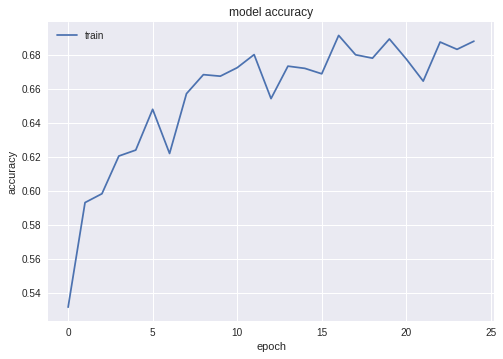

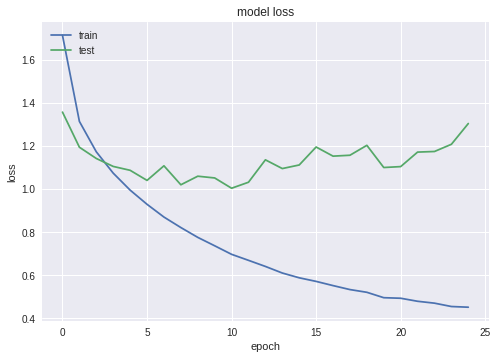

AttributeError: ignored

In [11]:
print(history.history.keys())

plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.save()